# Subspace-Search Variational Quantum Eigensolver(SSVQE)

Authors: Shah Ishmam Mohtashim, Turbasu Chatterjee, Arnav Das

*All are equally contributing authors*

## About the SSVQE


The variational quantum eigensolver (VQE) is an algorithm for searching the [ground state](https://en.wikipedia.org/wiki/Ground_state) of a quantum system. The Variational Quantum Eigensolver (VQE) is a flagship algorithm for quantum chemistry using near-term quantum computers. It uses the [Ritz variational principle](https://en.wikipedia.org/wiki/Ritz_method). In addition to the ground state, there are also phenomena such as photoresponse that are difficult to describe without the [excited states](https://en.wikipedia.org/wiki/Excited_state). Subspace-search VQE is used to find the excited states of a quantum system.


The SSVQE uses a simple technique to find the excited energy states. Using the appropriate [ansatz](https://en.wikipedia.org/wiki/Ansatz), VQE transforms the [basis state](https://en.wikipedia.org/wiki/Quantum_state#Basis_states_of_one-particle_systems) into the ground state. All quantum computing transformations are [unitary](https://en.wikipedia.org/wiki/Unitary_transformation). Unitary transformations maintains the angles between vectors, so orthogonal states before transformations remains as orthognal states after transformation. So, SSVQE transforms |0⋯0⟩ to the ground state, and another orthogonal basis state |0⋯1⟩ to the first excited state and so on. This method bypasses the need for a "swap test" which is necessary to measure the inner product between the states to check orthogonality. Bypassing the swap test means that the quantum circuit can constructed with lower number of SWAP gates resulting in a shallower efficent quantum circuit. Hence, the overall computational time and total error becomes lower. So, SSVQEs are advantageous for the current [NISQ devices](https://en.wikipedia.org/wiki/NISQ_computing).

As a demonstration, the weighted SSVQE is used to find out the excited states of a [Transverse Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model) with 4 spins and that of the Hydrogen molecule.

In [3]:
# Importing the necessary libraries

from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import pi
 
import pennylane as qml
from pennylane.templates import RandomLayers
#from pennylane.init import random_layers_uniform
from pennylane import broadcast
from pennylane import expval, var, device

##Overview of the SSVQE Algorithm

The procedures for SSVQE is as following:

1) Preparation of k initial states $\{\left|\varphi_{i}\right>\}_{i=0}^{k-1}$ orthogonal to each other.

2) Construct a parametrized quantum circuit $U(\theta)$ 

3) Minimize $L(\theta) = \sum_{i} w_{i} \left< \psi_{i} (\theta) \left| H \right| \psi_{i} (\theta)\right>$. Here, $w_{i}$ is the weight. 

First, we build the Hamiltonian. Next, we design the ansatz with the orthogonal basis states, and the cost function to evaluate the expectation value of the Hamiltonian. Finally, we select a classical optimizer, initialize the circuit parameters, and run the SSVQE algorithm using a PennyLane simulator.

Here we show 2 examples, one for __*Transverse Ising Model*__ and one for __*Lowest energy state of $\mathrm{H}_2$ molecule*__

# SSVQE for the Transverse Ising Model

Our Hamiltonian is given by $H = a \sum_{i=1}^{N}X_i + J \sum_{\langle i,j \rangle}^{N} Z_i Z_j$

Here, The [Pauli X](https://en.wikipedia.org/wiki/Pauli_matrices) term signifies the Transverse Field, [Pauli Z](https://en.wikipedia.org/wiki/Pauli_matrices) term denotes the Ising Spins, where each spin can be 1 or -1 and J is the nearest neighbour interaction strength term.

The simulation is done for N=4 spins.

In [4]:
H =  qml.PauliZ(0) @ qml.PauliZ(1) + qml.PauliZ(1) @ qml.PauliZ(2) + qml.PauliZ(2) @ qml.PauliZ(3)  + qml.PauliX(0) + qml.PauliX(1) + qml.PauliX(2) + qml.PauliX(3)

We define PennyLane’s standard qubit simulator as the device.





In [5]:
energies = np.zeros(2)

# Get the number of qubits in the Hamiltonian
num_qubits = len(H.wires)
 
# Initialize the device
dev = qml.device('default.qubit', wires=num_qubits)

##Ansatz for the weighted SSVQE

Here, The strongly entangling layer ansatz is defined as of [this paper](https://arxiv.org/abs/1804.00633). It consists of single qubit rotations and entanglers along with weights pertaining to each layer. On top of that, for the SSVQE to correctly function, a Pauli X gate is appended to each state vector corresponding to a state in the ansatz layer. This ansatz is not the same as one in [the paper](https://arxiv.org/pdf/1810.09434.pdf) but works equally well.

In [6]:
# Implements the weighted subspace search VQE [1810.09434]
 
# This ansatz works well enough, it's not the same as the one in the paper though
def ansatz(params, wires, state_idx=0):
    # Need to prepare a different orthogonal state each time
    qml.PauliX(wires=wires[state_idx])
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

Defining the weights and the sum of the expectation values

The total cost is a sum of expectation values for different orthogonal
starting states. Essentially the ansatz turns into something that can
simultaneously map the original starting states to the eigenstates.




In [7]:
single_cost = qml.ExpvalCost(ansatz, H, dev)
 
# Weight vector - weights the different eigenstates in the cost function so
# that it's the lowest ones that are found
w = np.arange(num_qubits, 0, -1)

/home/marc/.local/lib/python3.10/site-packages/pennylane/vqe/vqe.py:155: PennyLaneDeprecationWarning: ExpvalCost is deprecated, use qml.expval() instead. For optimizing Hamiltonian measurements with measuring commuting terms in parallel, use the grouping_type keyword in qml.Hamiltonian.
  warnings.warn(


In [8]:
# The full cost - computes single_cost for each starting state
def total_cost(params):
    cost = 0
    for state_idx in range(num_qubits):
        cost += w[state_idx] * single_cost(params, state_idx=state_idx)
    return cost

Here, we set up the optimizer and initialize the parameters for the variational quantum eigensolver. We have used the [Adam Optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and 8 layers of the ansatz as defined above.

In [9]:
# Set up a cost function and optimizer, and run the SSVQE
opt = qml.AdamOptimizer(stepsize=0.05)
max_iterations = 200
costs = []

# Initial parameters for the ansatz
num_layers = 8
params = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, num_qubits, 3))

Now, we run our optmization. At each step of the optimizer, we evaluate the single cost functions for the corresponding eigenstates i.e. we evaluate the cost function for the ground energy and the first excited state. 

In [10]:
# Optimize!
Ising_callback_energies = []
Ising_callback_energies_single_0 = []
Ising_callback_energies_single_1 = []

for _ in range(max_iterations):
    params, prev_energy = opt.step_and_cost(total_cost, params)
    energy = total_cost(params)
    energy_ground_state = single_cost(params, state_idx=0)
    energy_first_excited_state = single_cost(params, state_idx=1)
    Ising_callback_energies_single_0.append(energy_ground_state)
    Ising_callback_energies_single_1.append(energy_first_excited_state)
    Ising_callback_energies.append(energy)

In [11]:
# After optimization, get the energies for the original starting states
for state_idx in range(2):
    energies[state_idx] = single_cost(params, state_idx=state_idx)

In [12]:
energies = ",".join([str(E) for E in energies])

The ground state energy and the first excited state are


In [13]:
energies

'-4.597075707429223,-4.166306199760912'

##Plotting the energy levels of the Transverse Ising Model as it is subjected to the SSVQE

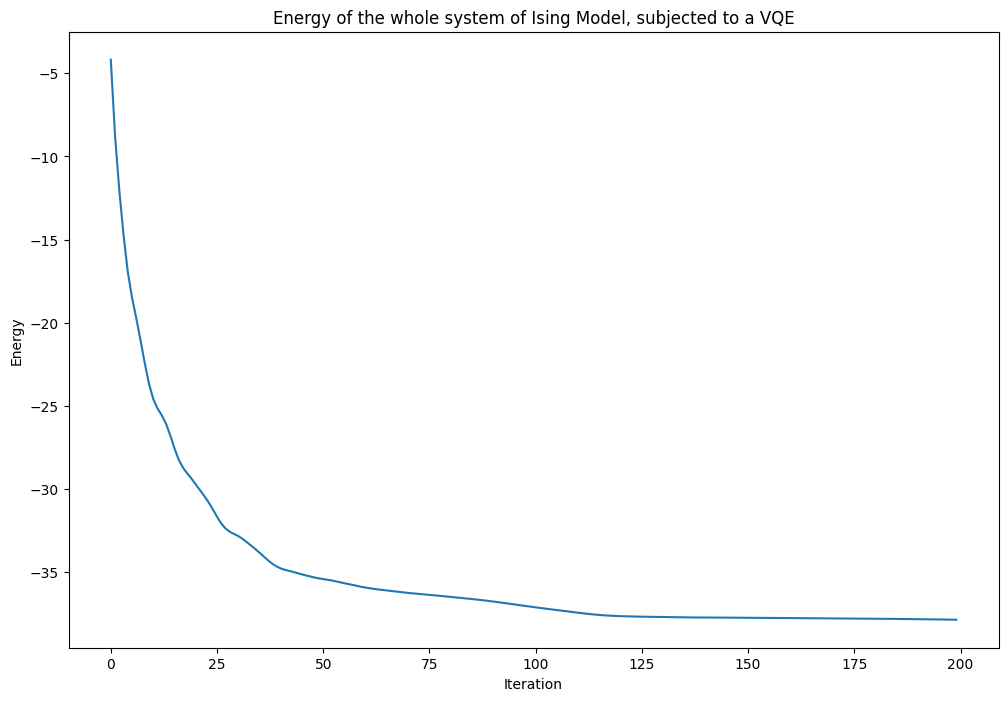

In [14]:
# corresponding y axis values
x = [*range(0,200)]

y =  Ising_callback_energies

plt.figure(figsize=(12, 8)) 
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('Energy')
  
# giving a title to my graph
plt.title('Energy of the whole system of Ising Model, subjected to a VQE')
  
# function to show the plot
plt.show()

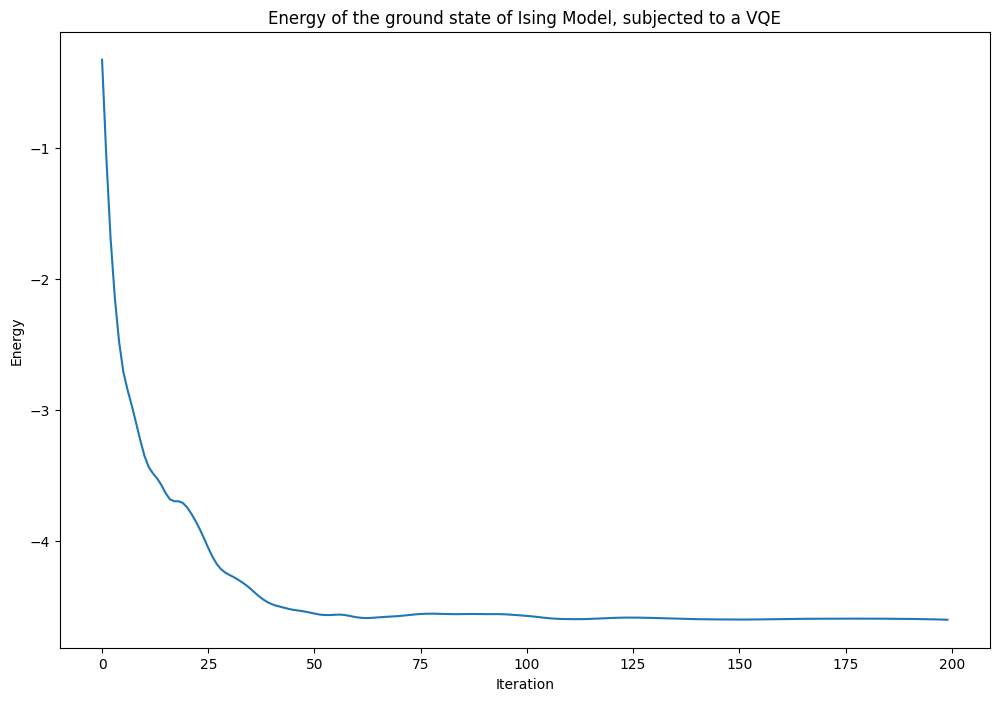

In [15]:
# corresponding y axis values
y =  Ising_callback_energies_single_0

plt.figure(figsize=(12, 8)) 
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('Energy')
  
# giving a title to my graph
plt.title('Energy of the ground state of Ising Model, subjected to a VQE')
  
# function to show the plot
plt.show()

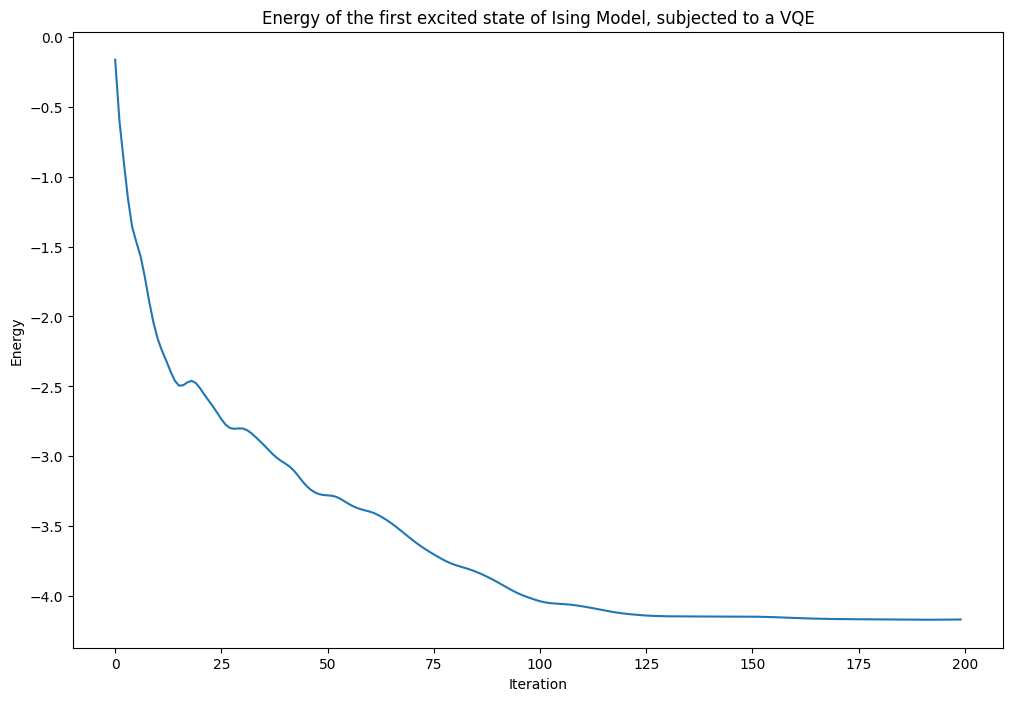

In [16]:
# corresponding y axis values
y =  Ising_callback_energies_single_1

plt.figure(figsize=(12, 8)) 
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('Energy')
  
# giving a title to my graph
plt.title('Energy of the first excited state of Ising Model, subjected to a VQE')
  
# function to show the plot
plt.show()

#SSVQE for the $\mathrm{H}_2$ molecule

Here, we have followed the exact same procedure as we have done for the Transverse Ising model simulation. The only difference is in building the Hamiltonian, which we have described as follows: 

We have to load the structure of the molecule we want to simulate. This is done by specify the symbols of the constituent atoms and a one-dimensional array with the corresponding nuclear coordinates in atomic units. For this example, we load the $\mathrm{H}_2$ molecule and its nuclear coordinates.

In [17]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

The molecular hamiltonian is built with minimal basis set confiugation the number of qubits required for this simulation is displayed as well. We have four spin orbitals so we will need 4 qubits.

In [18]:
h, qubits =  qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        charge=0,
        mult=1,
        basis='sto-3g',
        active_electrons=2,
        active_orbitals=2
)

print("Number of qubits = ", qubits)
print("The Hamiltonian is ", h)

Number of qubits =  4
The Hamiltonian is    (-0.24274501260941428) [Z3]
+ (-0.24274501260941422) [Z2]
+ (-0.04207255194743911) [I0]
+ (0.17771358229091763) [Z0]
+ (0.17771358229091766) [Z1]
+ (0.12293330449299356) [Z0 Z2]
+ (0.12293330449299356) [Z1 Z3]
+ (0.1676833885560135) [Z0 Z3]
+ (0.1676833885560135) [Z1 Z2]
+ (0.17059759276836797) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.04475008406301993) [Y0 Y1 X2 X3]
+ (-0.04475008406301993) [X0 X1 Y2 Y3]
+ (0.04475008406301993) [Y0 X1 X2 Y3]
+ (0.04475008406301993) [X0 Y1 Y2 X3]


We define PennyLane’s standard qubit simulator as the device.

In [19]:
energies = np.zeros(2)


# Get the number of qubits in the Hamiltonian
num_qubits = len(h.wires)

# Initialize the device
dev = qml.device('default.qubit', wires=num_qubits)

Constructing the Ansatz for the subspace search VQE

In [20]:
# Ansatz
def ansatz(params, wires, state_idx=0):
    # Need to prepare a different orthogonal state each time
    qml.PauliX(wires=wires[state_idx])
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

Defining the weights and the sum of the expectation values


In [21]:
single_cost = qml.ExpvalCost(ansatz, h, dev)
w = np.arange(num_qubits, 0, -1)

Defining the total cost for different orthogonal starting states.



In [22]:
# The full cost - computes single_cost for each starting state
def total_cost(params):
    cost = 0
    for state_idx in range(num_qubits):
        cost += w[state_idx] * single_cost(params, state_idx=state_idx)
    return cost

Defining the optimizer, number of maximum iterations, number of layers, etc...

In [23]:
# Set up a cost function and optimizer, and run the SSVQE
opt = qml.AdamOptimizer(stepsize=0.05)
max_iterations = 200
costs = []

# Initial parameters for the ansatz
num_layers = 8
params = np.random.uniform(low=0, high=2*np.pi, size=(num_layers, num_qubits, 3))

And finally running the optimizer to evaluate the single cost functions for the corresponding eigenstates i.e. evaluating the cost function for the ground energy and the first excited state. 

In [24]:
# Optimize!
H2_callback_energies = []
H2_callback_energies_single_0 = []
H2_callback_energies_single_1 = []

for _ in range(max_iterations):
    params, prev_energy = opt.step_and_cost(total_cost, params)
    energy = total_cost(params)
    energy_ground_state = single_cost(params, state_idx=0)
    energy_first_excited_state = single_cost(params, state_idx=1)
    H2_callback_energies_single_0.append(energy_ground_state)
    H2_callback_energies_single_1.append(energy_first_excited_state)
    H2_callback_energies.append(energy)

In [25]:
# After optimization, get the energies for the original starting states
for state_idx in range(2):
    energies[state_idx] = single_cost(params, state_idx=state_idx)

In [26]:
energies = ",".join([str(E) for E in energies])

The ground state energy and the first excited state energy are as follows:

In [27]:
energies

'-1.1343342297086605,-0.5119306170087006'

##Plotting the energy levels of the $H_2$ molecule as it is subjected to the SSVQE

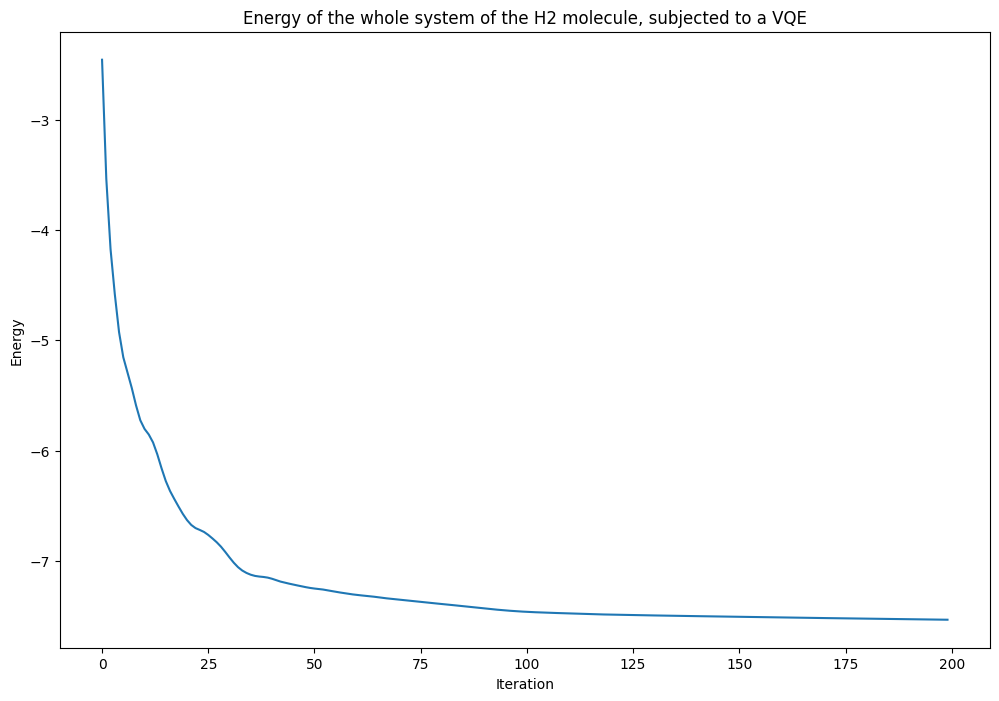

In [28]:
# importing the required module
import matplotlib.pyplot as plt
  
# x axis values
x = [*range(0,200)]
# corresponding y axis values
y =  H2_callback_energies

plt.figure(figsize=(12, 8)) 
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('Energy')
  
# giving a title to my graph
plt.title('Energy of the whole system of the H2 molecule, subjected to a VQE')
  
# function to show the plot
plt.show()

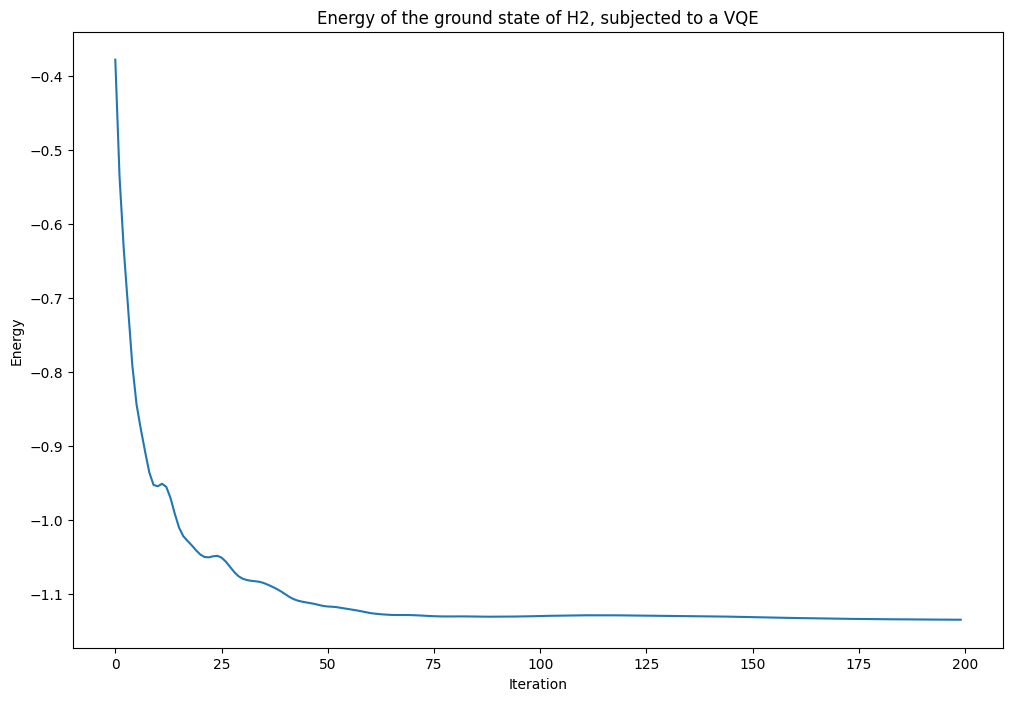

In [29]:
# corresponding y axis values
y =  H2_callback_energies_single_0

plt.figure(figsize=(12, 8)) 
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('Energy')
  
# giving a title to my graph
plt.title('Energy of the ground state of H2, subjected to a VQE')
  
# function to show the plot
plt.show()

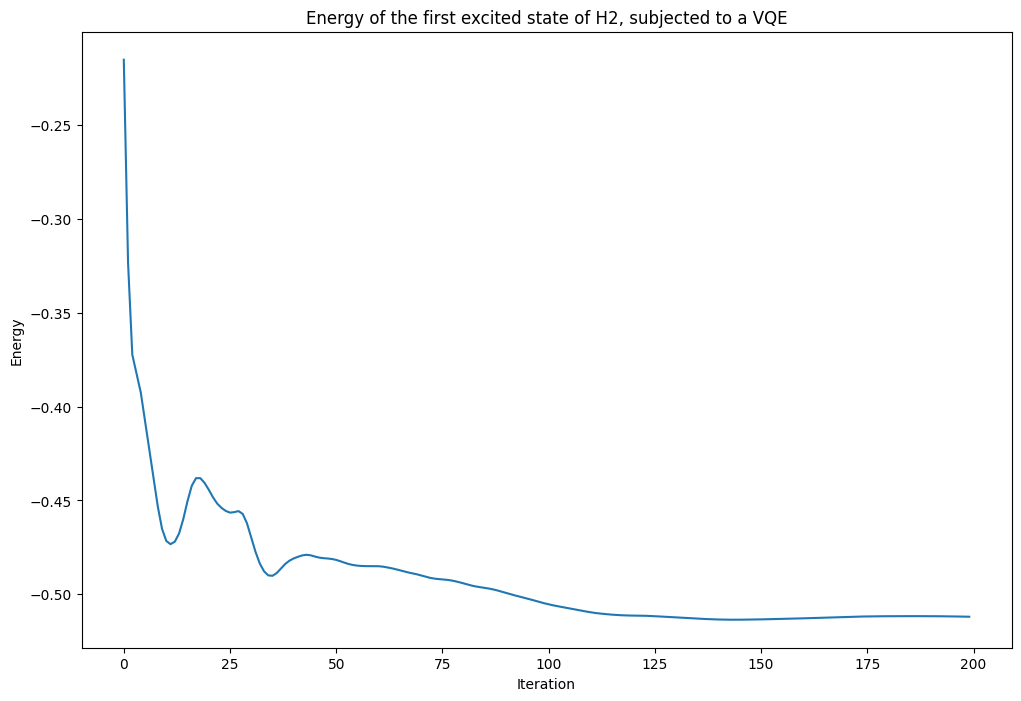

In [30]:
# corresponding y axis values
y =  H2_callback_energies_single_1

plt.figure(figsize=(12, 8)) 
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Iteration')
# naming the y axis
plt.ylabel('Energy')
  
# giving a title to my graph
plt.title('Energy of the first excited state of H2, subjected to a VQE')
  
# function to show the plot
plt.show()

In [34]:
spectral_gap = single_cost(params, state_idx=0) - single_cost(params, state_idx=1)

In [35]:
print("spectral-gap of H2: ", spectral_gap)

spectral-gap of H2:  -0.6224036126999599
